In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/archive (2)/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
df.columns

Index(['id_code', 'diagnosis', 'binary_type', 'type'], dtype='object')

In [ ]:
df['type'].value_counts()

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: type, dtype: int64

<Axes: >

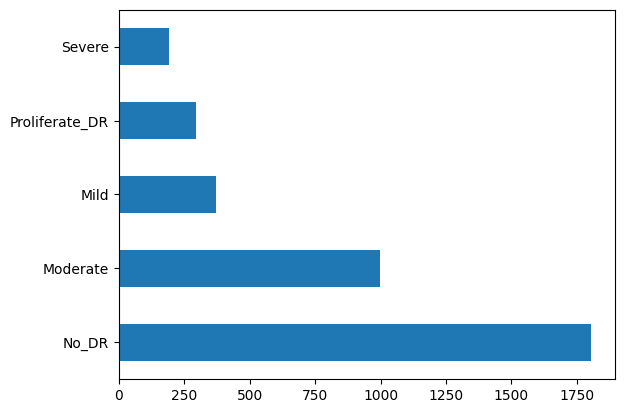

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

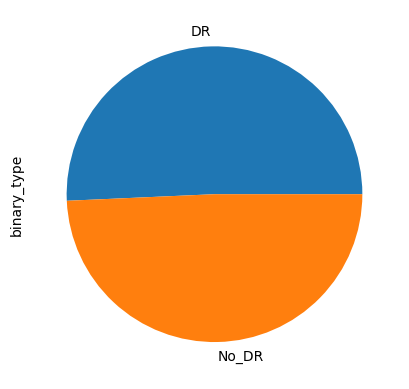

In [ ]:
df['binary_type'].value_counts().plot(kind='pie')

In [ ]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("Train")
print(train['type'].value_counts(), '\n')
print("Valid")
print(val['type'].value_counts(), '\n')
print("Test")
print(test['type'].value_counts(), '\n')

Train
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

Valid
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

Test
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [ ]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
#print(test['type'].value_counts(), '\n')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
src_dir = '/content/drive/MyDrive/archive (2)/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [ ]:
train_path = 'train'
val_path = 'val'
test_path = 'test'
print(train_path)
print(val_path)
print(test_path)

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = True)

train
val
test
Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [ ]:
os.listdir('train')

['Proliferate_DR', 'Severe', 'Moderate', 'No_DR', 'Mild']

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

history = model.fit(train_batches,
                    epochs=12,
                    validation_data=val_batches)

Epoch 1/12
81/81 [==============================] - 199s 2s/step - loss: 0.7190 - acc: 0.2830 - auc: 0.5951 - f1_score: 0.2991 - cohen_kappa: 0.1225 - val_loss: 0.6664 - val_acc: 0.0800 - val_auc: 0.5705 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 2/12
81/81 [==============================] - 183s 2s/step - loss: 0.6345 - acc: 0.5422 - auc: 0.7318 - f1_score: 0.5278 - cohen_kappa: 0.3309 - val_loss: 0.6468 - val_acc: 0.2727 - val_auc: 0.6005 - val_f1_score: 0.1169 - val_cohen_kappa: 0.0000e+00
Epoch 3/12
81/81 [==============================] - 176s 2s/step - loss: 0.6077 - acc: 0.5730 - auc: 0.7320 - f1_score: 0.5628 - cohen_kappa: 0.3596 - val_loss: 0.6468 - val_acc: 0.0800 - val_auc: 0.5524 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 4/12
81/81 [==============================] - 173s 2s/step - loss: 0.5628 - acc: 0.5851 - auc: 0.7574 - f1_score: 0.5783 - cohen_kappa: 0.3762 - val_loss: 0.5908 - val_acc: 0.2255 - val_auc: 0.5859 - val_f1_score: 0.1456 - 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
acc = model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc[1])

<ipython-input-15-067bbc153377>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 17s 982ms/step - loss: 0.2529 - acc: 0.7273 - auc: 0.9246 - f1_score: 0.6881 - cohen_kappa: 0.5750
Accuracy:  0.7272727489471436


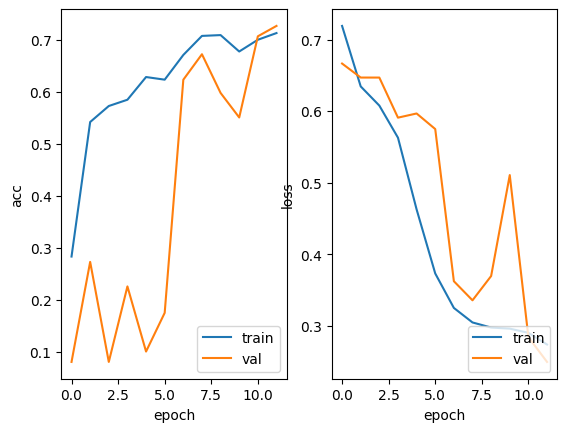

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 [==============================] - 13s 696ms/step
The first 5 predictions: ['Moderate', 'Mild', 'Moderate', 'Moderate', 'Moderate']
